In [1]:
import numpy as np
from skimage.io import imread, imsave
from skimage import img_as_ubyte
from matplotlib import pyplot as plt

from platform import python_version

%matplotlib inline

np.__version__, python_version()

('1.18.5', '3.8.3')

### Raw images and input

(1166, 449)
(9627, 3702)


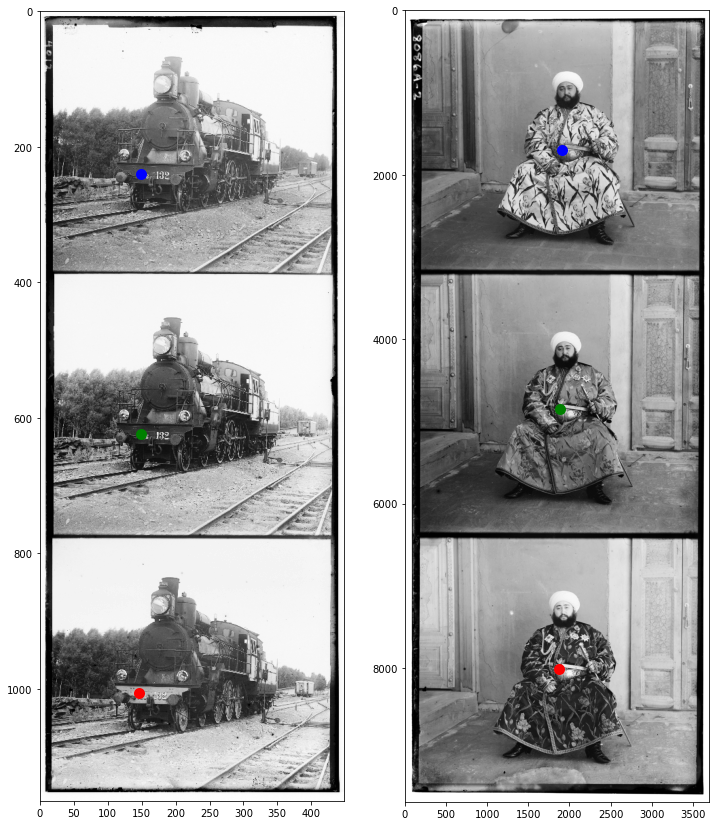

In [290]:
plt.figure(figsize=(12,18))

plt.subplot(1, 2, 1)

small_image = imread('tests/03_test_img_input/img.png')
print(small_image.shape)

with open('tests/03_test_img_gt/gt.csv', 'r') as f:
    ans = f.read()
    gt_b_row, gt_b_col, _, _, gt_r_row, gt_r_col, _ = map(int, ans.split(',')[1:])
    
with open('tests/03_test_img_input/g_coord.csv', 'r') as f:
    inpud = f.read()
    g_row, g_col = map(int, inpud.split(','))

plt.imshow(small_image, cmap='gray')
plt.scatter(x=[gt_b_col], y=[gt_b_row], linewidths=5, c='blue')
plt.scatter(x=[g_col], y=[g_row], linewidths=5, c='green')
plt.scatter(x=[gt_r_col], y=[gt_r_row], linewidths=5, c='red')

plt.subplot(1, 2, 2)

big_image = imread('tests/19_test_img_input/img.png')
print(big_image.shape)

with open('tests/19_test_img_gt/gt.csv', 'r') as f:
    ans = f.read()
    gt_b_row, gt_b_col, _, _, gt_r_row, gt_r_col, _ = map(int, ans.split(',')[1:])
    
with open('tests/19_test_img_input/g_coord.csv', 'r') as f:
    inpud = f.read()
    g_row, g_col = map(int, inpud.split(','))
    
plt.imshow(big_image, cmap='gray')
plt.scatter(x=[gt_b_col], y=[gt_b_row], linewidths=5, c='blue')
plt.scatter(x=[g_col], y=[g_row], linewidths=5, c='green')
plt.scatter(x=[gt_r_col], y=[gt_r_row], linewidths=5, c='red')

### Combine images "as is" without proper shift

In [327]:
def cut_img(raw_img, cut_edges=0.1):
    h, w = raw_img.shape
    hh = h//3
    h_cut, w_cut = int(hh * cut_edges), int(w * cut_edges)
    B = raw_img[:hh][h_cut:-h_cut, w_cut:-w_cut]
    G = raw_img[hh:2*hh][h_cut:-h_cut, w_cut:-w_cut]
    R = raw_img[2*hh:3*hh][h_cut:-h_cut, w_cut:-w_cut]
    return B, G, R

(312, 361) (312, 361) (312, 361)


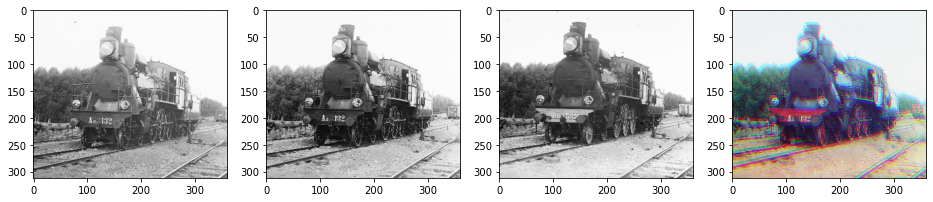

In [328]:
B, G, R = cut_img(small_image)
print(B.shape, G.shape, R.shape)

plt.figure(figsize=(16,7))
for i, img in enumerate([B, G, R]):
    plt.subplot(1, 4, i+1)
    plt.imshow(img, cmap='gray')
    
plt.subplot(1, 4, 4)
plt.imshow(np.dstack([R, G, B]))

### Apply Fourier transformation to find an optimal shift and compare it with "as is"

In [329]:
def shift_image(image, dv, du):
    image = np.roll(image, du, axis=0)
    image = np.roll(image, dv, axis=1)
    if du > 0:
        image[:du,:] = 0
    else:
        image[du:,:] = 0
    if dv > 0:
        image[:,:dv] = 0
    else:
        image[:,dv:] = 0
    return image

In [330]:
def normalize_shift(u, v, h, w):
    if np.abs(u) > h/2:
        u = u - h * np.sign(u)
    if np.abs(v) > w/2:
        v = v - w * np.sign(v)
    return u, v

def get_shift_Fourier_transform(I1, I2):
    # h,w ~ u,v
    h, w = I1.shape
    FI1 = np.fft.fft2(I1)
    FI2_conj = np.conjugate(np.fft.fft2(I2))
    C = np.fft.ifft2(FI1 * FI2_conj)
    u, v = np.unravel_index(np.argmax(C), (h, w))
    u, v = normalize_shift(u, v, h, w)
    return u, v

In [331]:
%%time
R_u, R_v = get_shift_Fourier_transform(G, R)
B_u, B_v = get_shift_Fourier_transform(G, B)

CPU times: user 35.8 ms, sys: 1.84 ms, total: 37.7 ms
Wall time: 36 ms


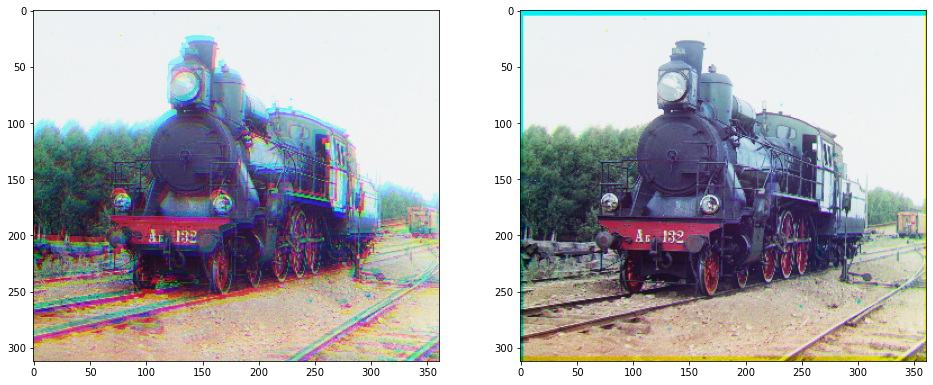

In [332]:
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.imshow(np.dstack([R, G, B]))

plt.subplot(1, 2, 2)
new_image = np.dstack([shift_image(R, R_v, R_u),
                       G,
                       shift_image(B, B_v, B_u)])
plt.imshow(new_image)

In [301]:
def align(img, g_coord):
    '''
    Get raw image and Green point, return aligned image and corresponding points in Blue and Red channels
    Channel order: Blue, Green, Red (BGR)
    '''
    h_shift = img.shape[0]//3
    g_row, g_col = g_coord
    B, G, R = cut_img(img)
    R_u, R_v = get_shift_Fourier_transform(G, R)
    B_u, B_v = get_shift_Fourier_transform(G, B)
    aligned_img = np.dstack([shift_image(R, R_v, R_u),
                             G,
                             shift_image(B, B_v, B_u)])
    # row,col ~ u,v
    b_row, b_col = g_row - B_u - h_shift, g_col - B_v
    r_row, r_col = g_row - R_u + h_shift, g_col - R_v
    return aligned_img, (b_row, b_col), (r_row, r_col)

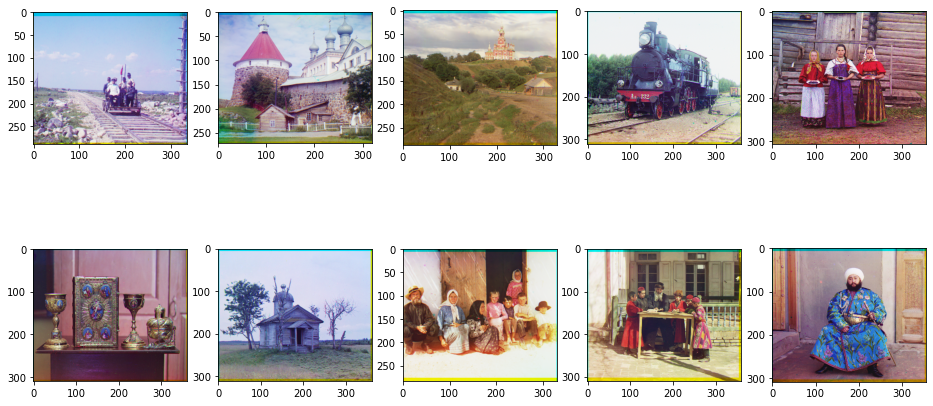

In [302]:
plt.figure(figsize=(16,8))

for i in range(10):
    plt.subplot(2, 5, i+1)
    aligned_img, _, _ = align(imread(f'tests/0{i}_test_img_input/img.png'), (0,0))
    plt.imshow(aligned_img)